In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

In [4]:
# tree visualization

In [5]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree = DecisionTreeClassifier(max_depth=2, criterion='entropy')
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

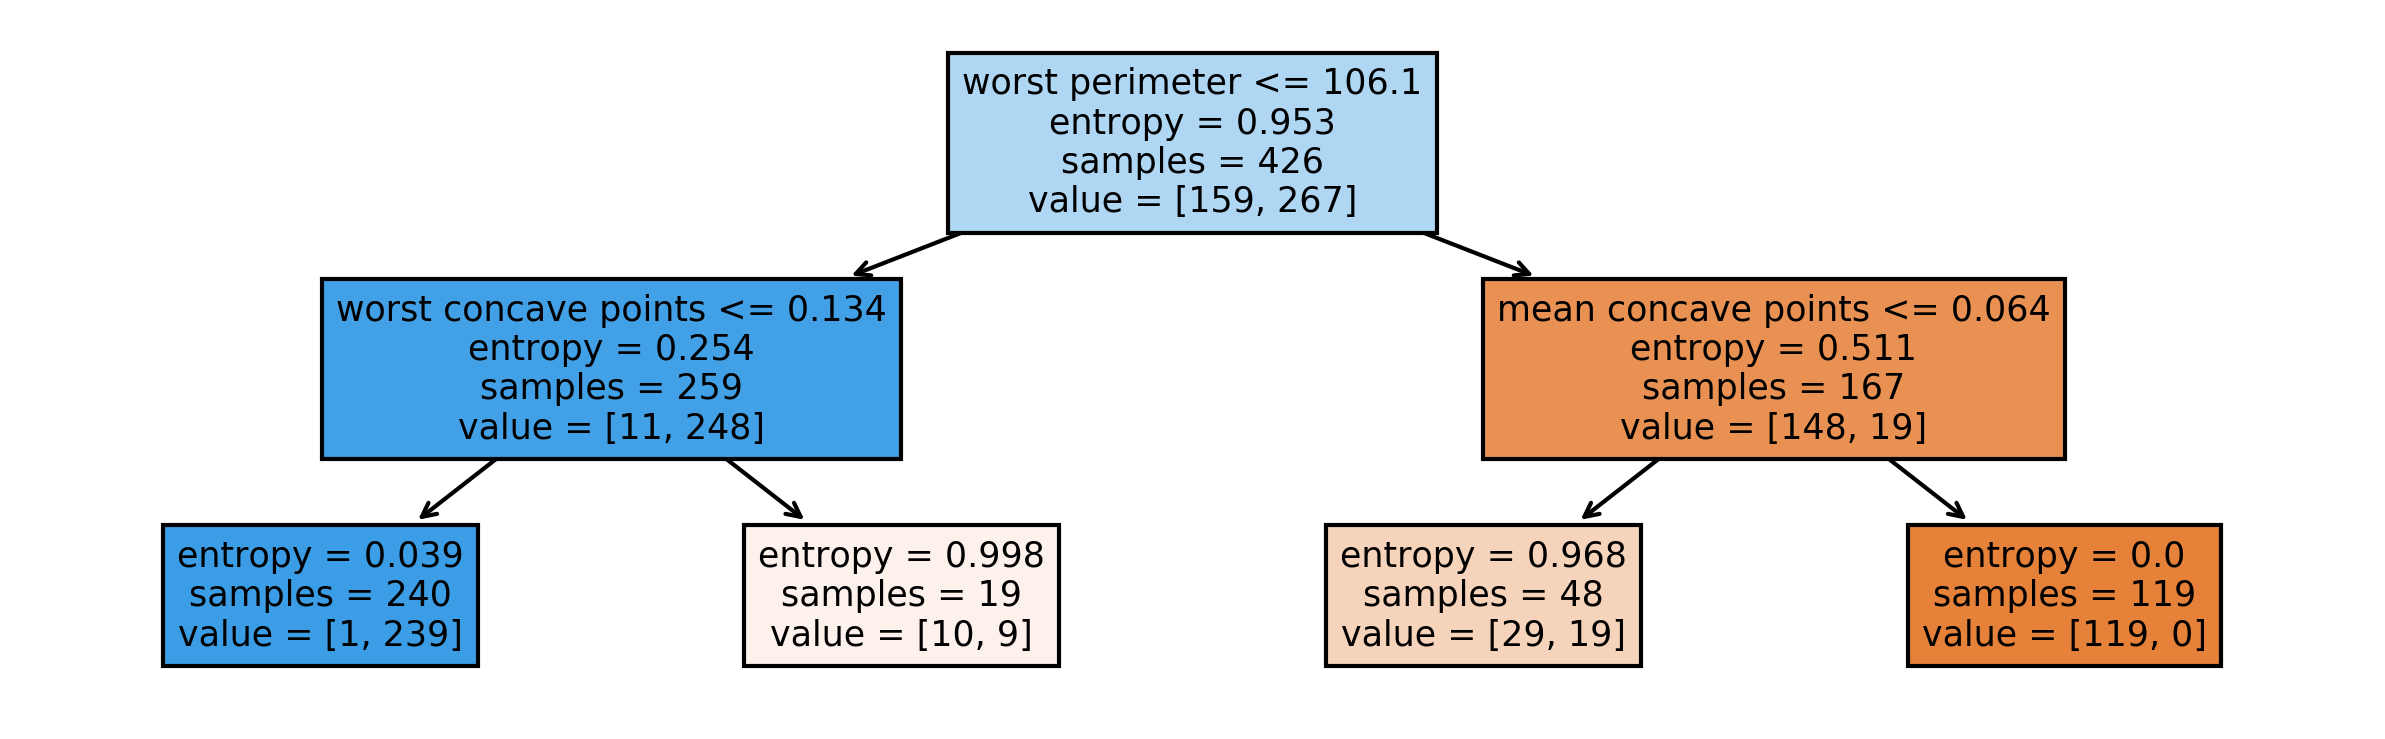

In [6]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(tree, feature_names=cancer.feature_names, filled=True)
plt.savefig("images/mpl_tree_plot.png")

# Parameter Tuning

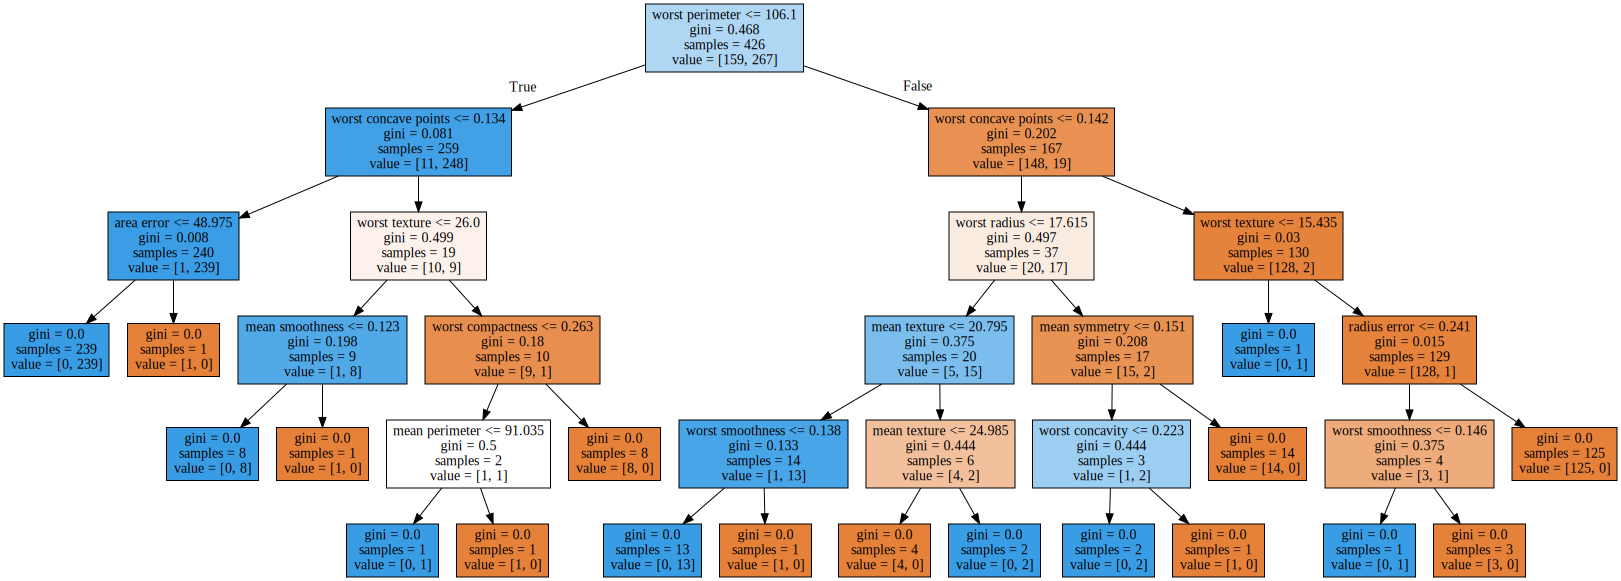

In [7]:
import graphviz
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/no_pruning", cleanup=True)
graph

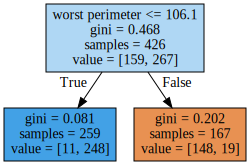

In [8]:
tree = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/max_depth_1", cleanup=True)
graph

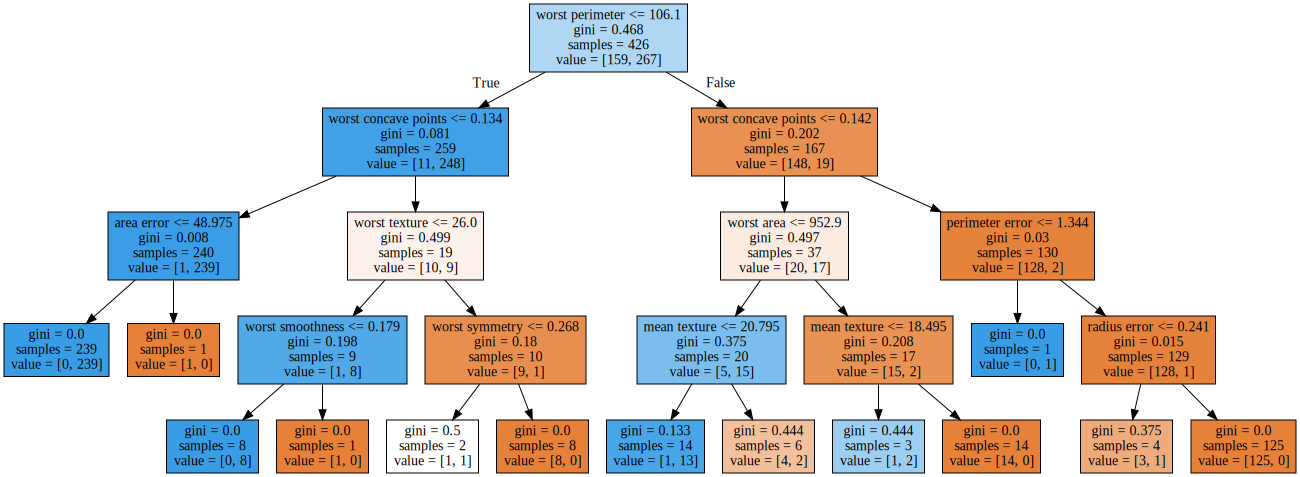

In [9]:
tree = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/max_depth_4", cleanup=True)
graph

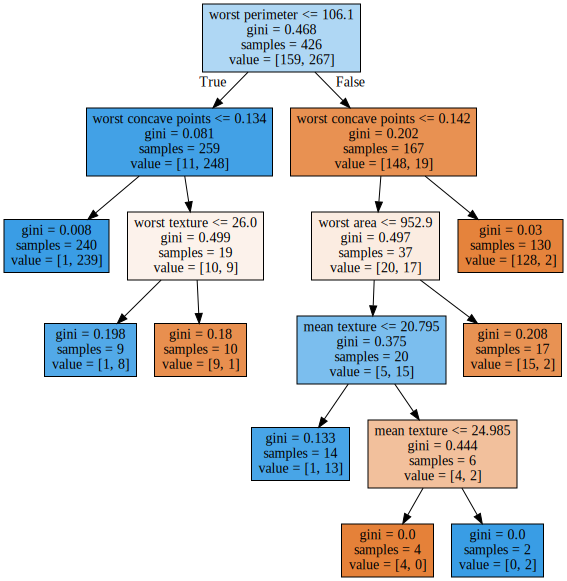

In [10]:
tree = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/max_leaf_nodes_8", cleanup=True)
graph

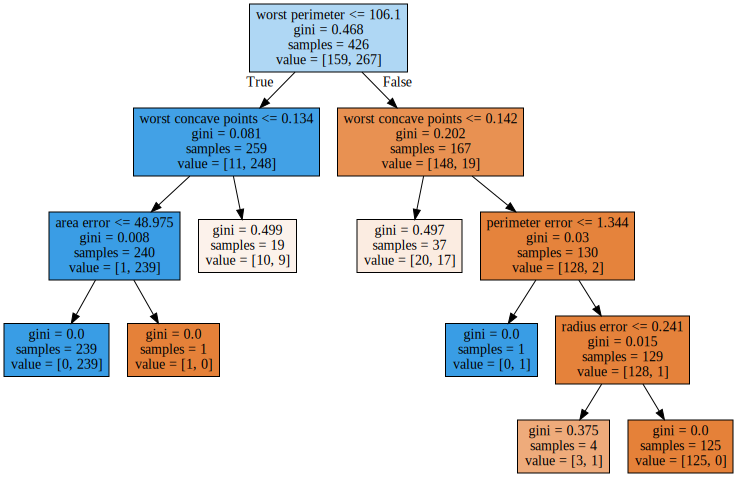

In [11]:
tree = DecisionTreeClassifier(min_samples_split=50).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=cancer.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/min_samples_split_50", cleanup=True)
graph

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 7)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False

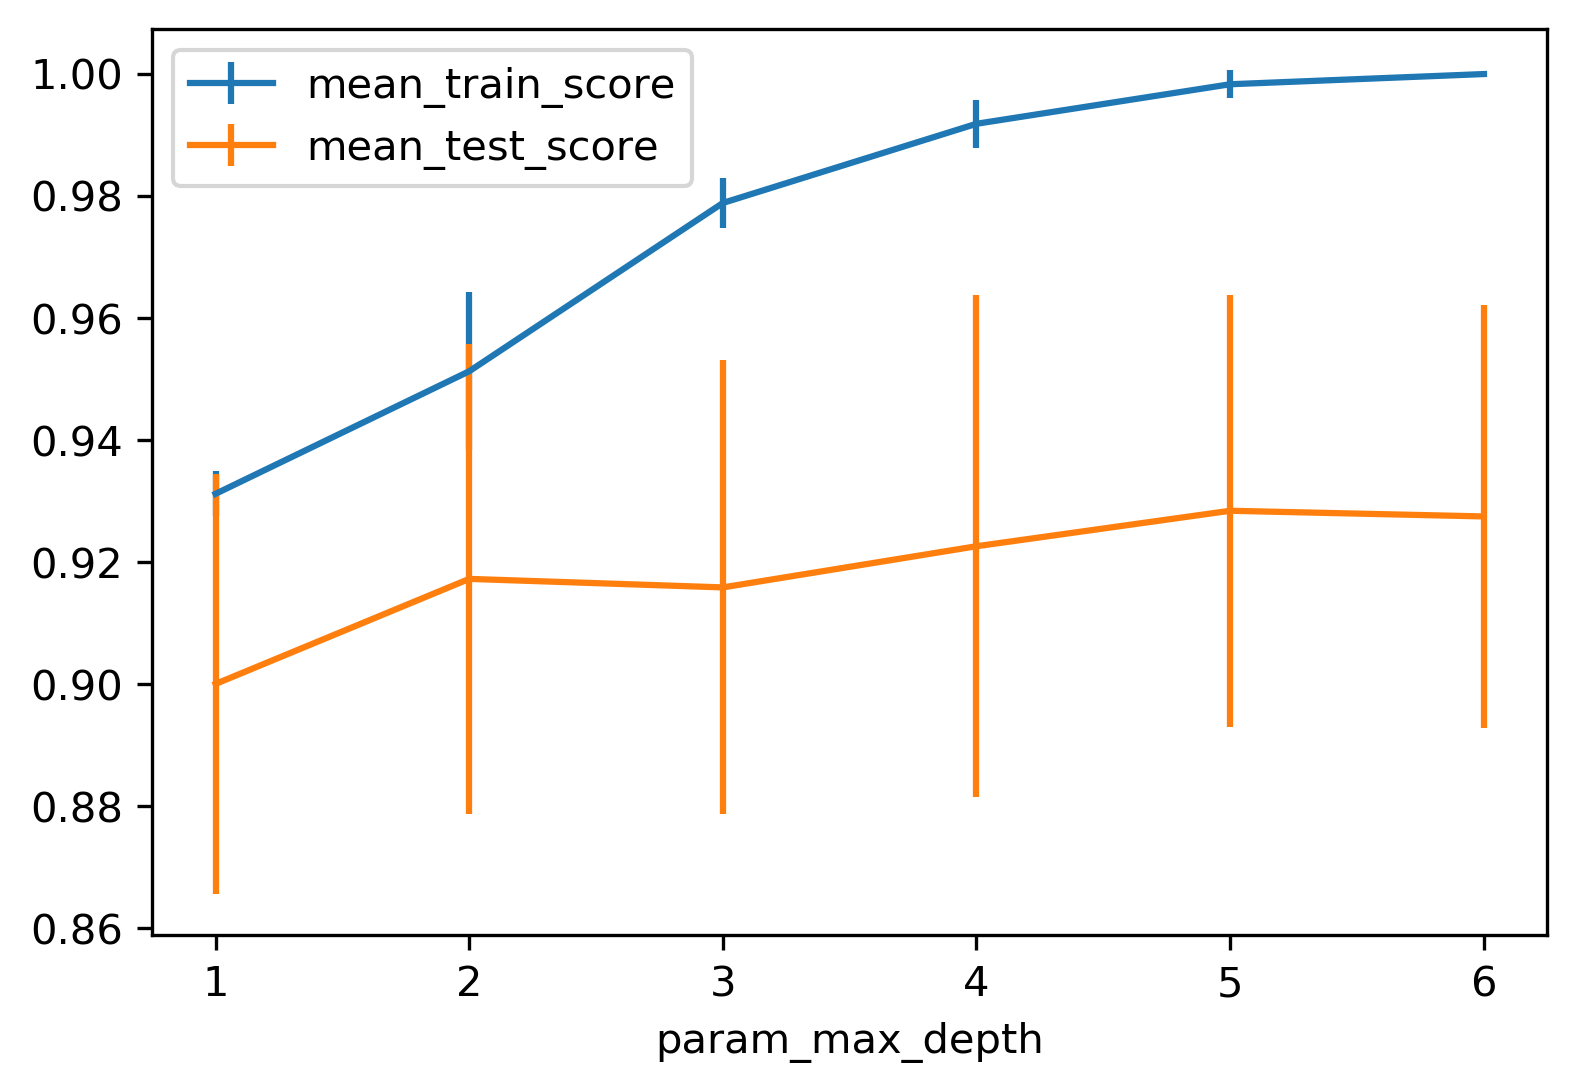

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
param_grid = {'max_depth':range(1, 7)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=StratifiedShuffleSplit(100), return_train_score=True)
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_depth', y='mean_test_score', yerr='std_test_score', ax=plt.gca())
plt.savefig("images/grid_max_depth.png")

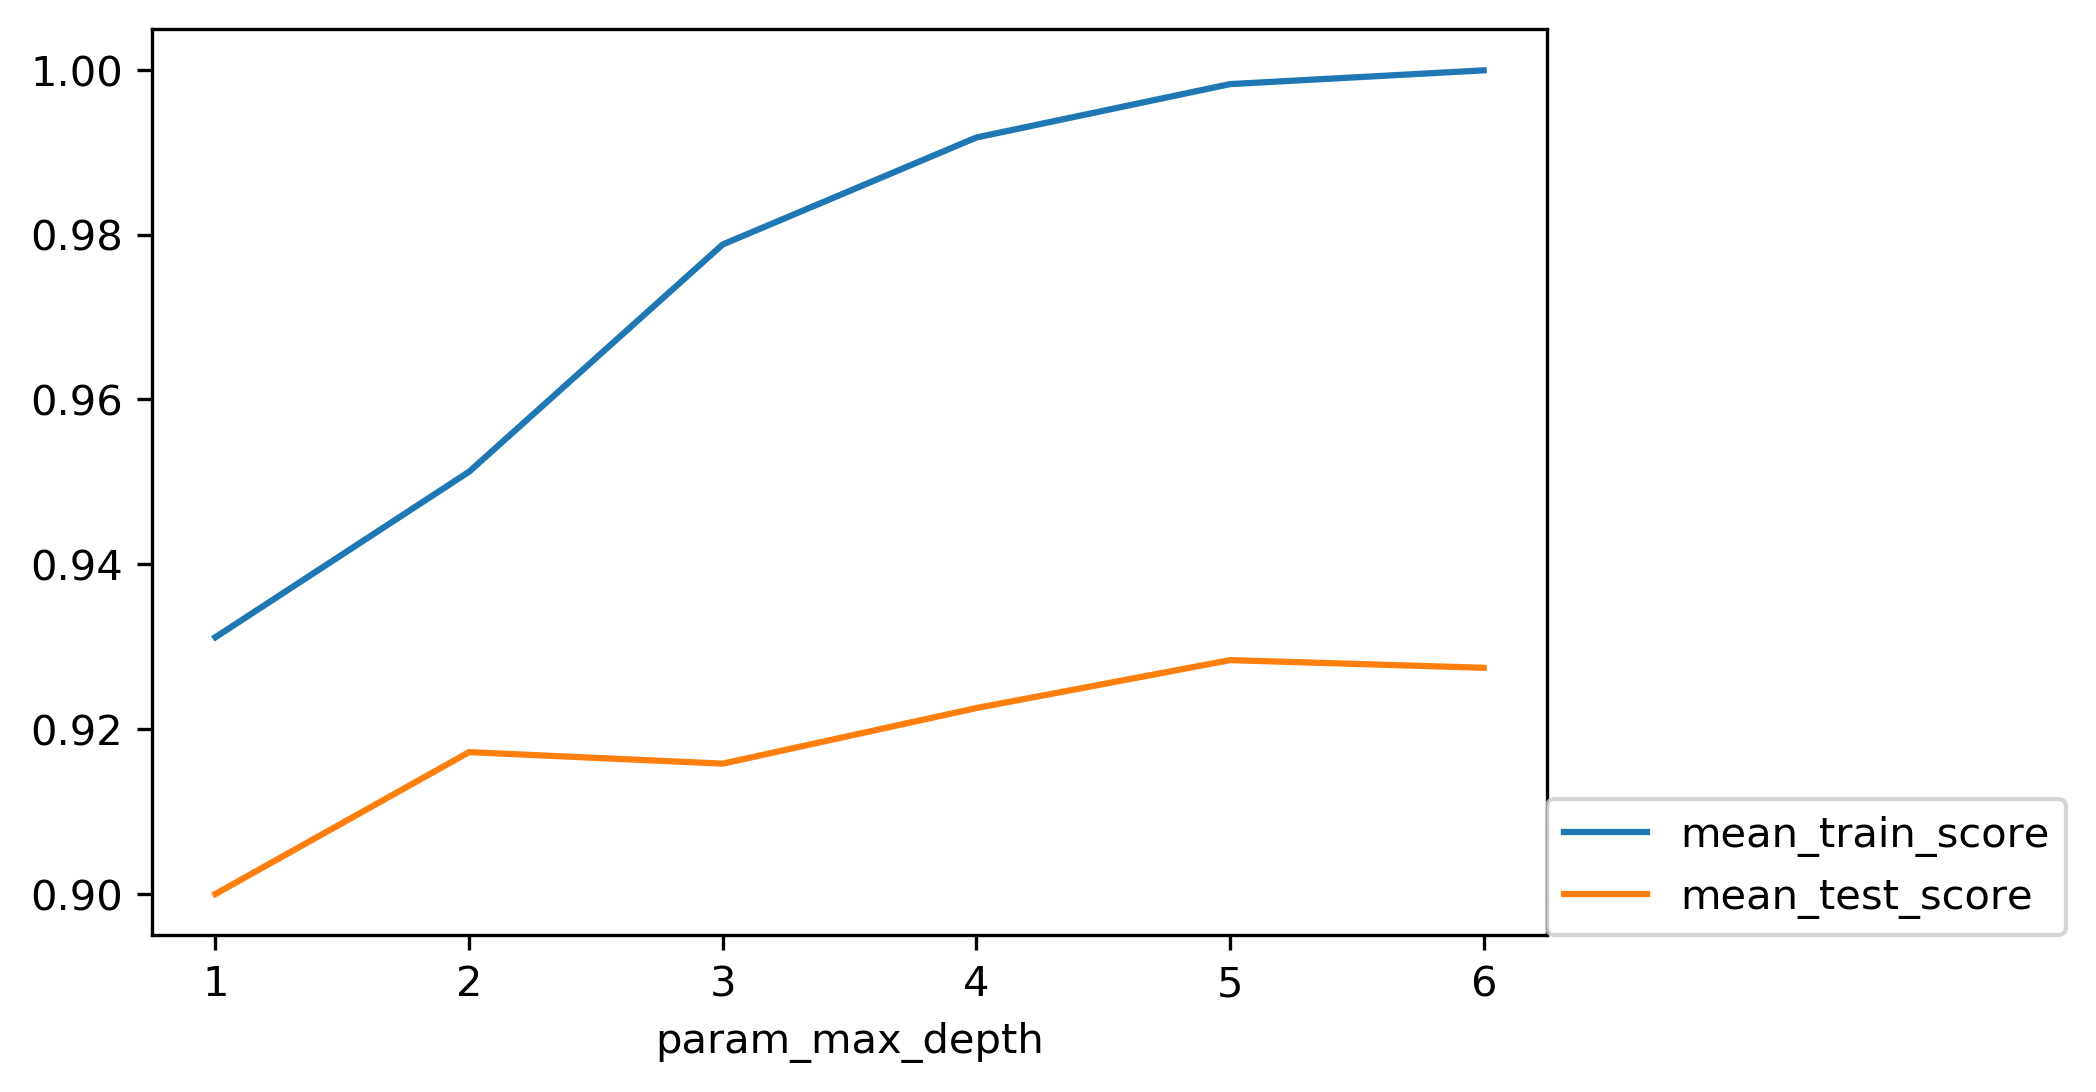

In [14]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_depth', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))

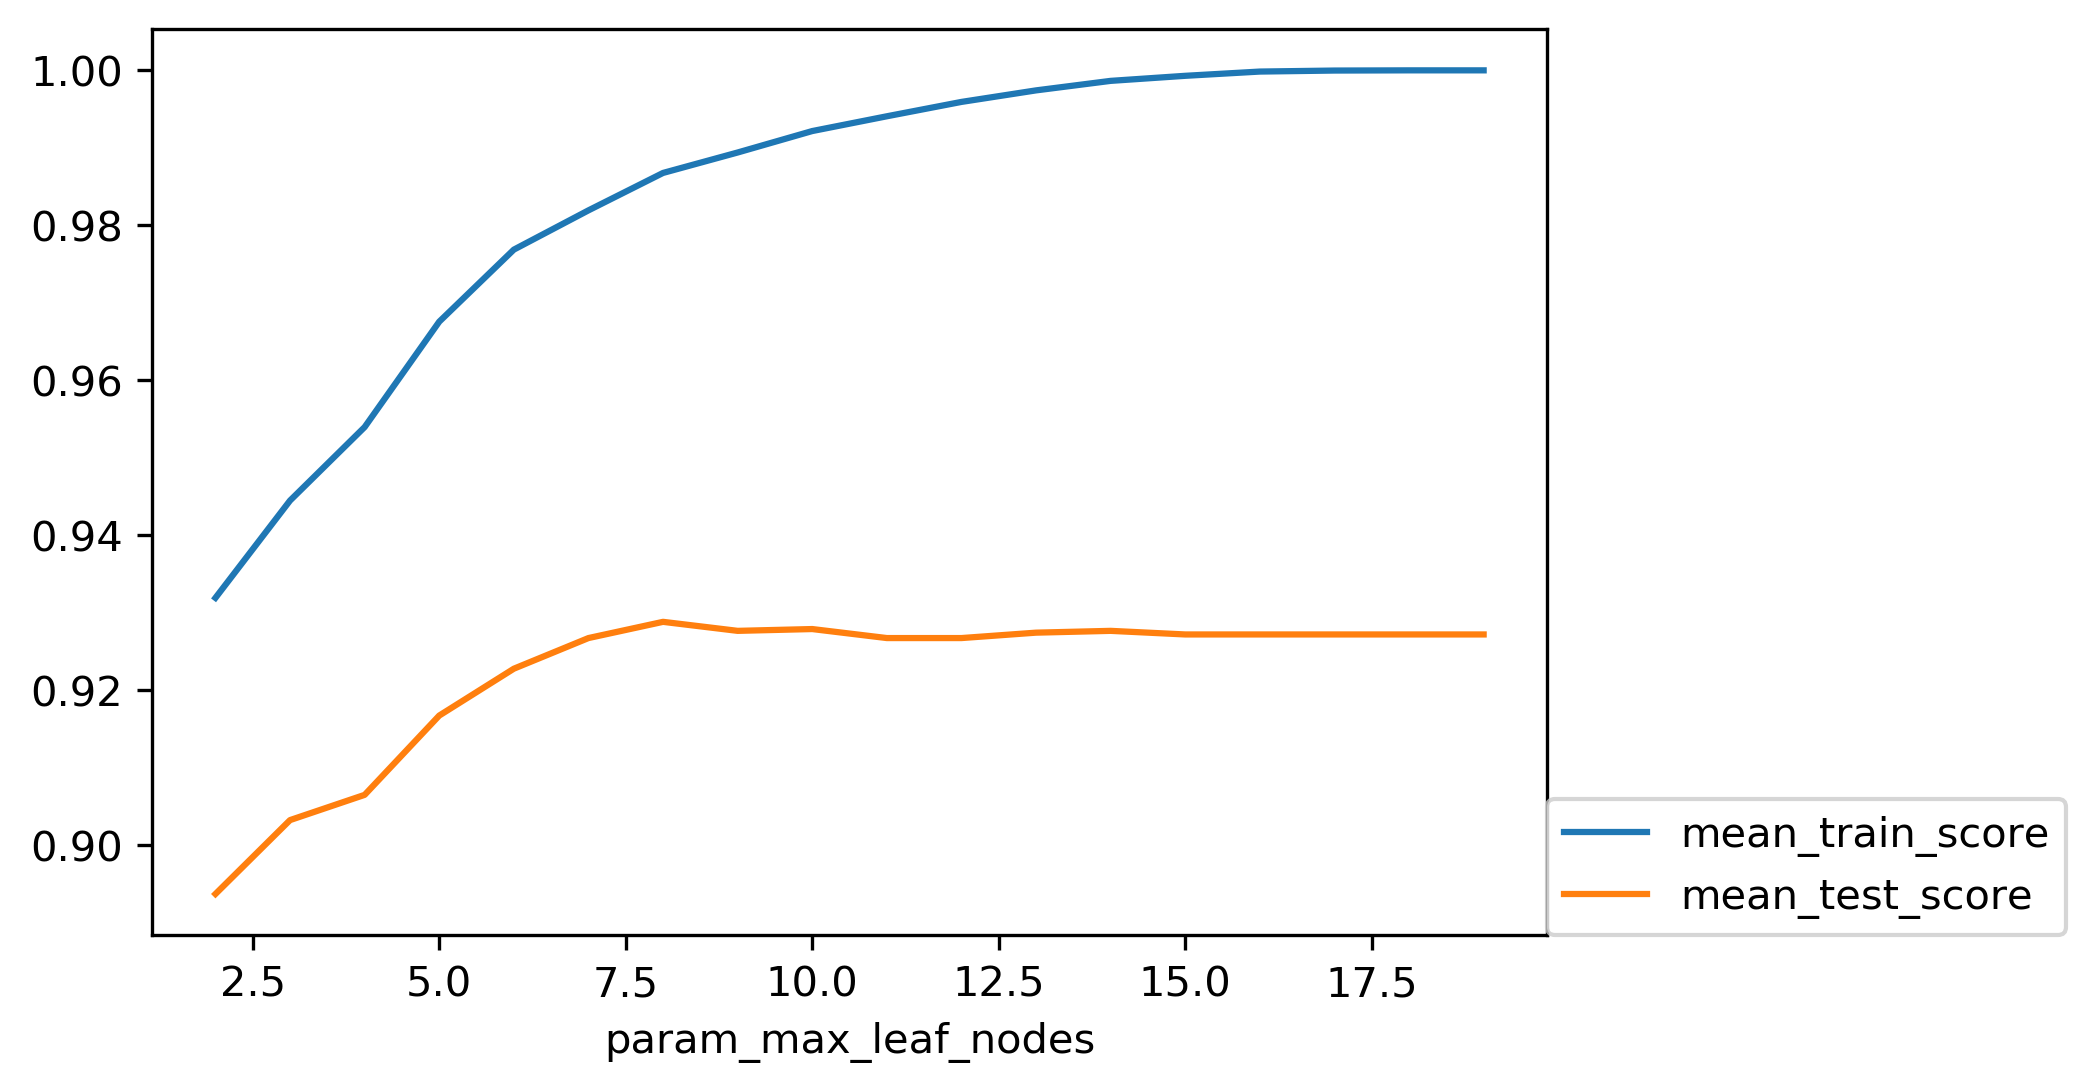

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_leaf_nodes':range(2, 20)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=StratifiedShuffleSplit(100, random_state=1), return_train_score=True)
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))

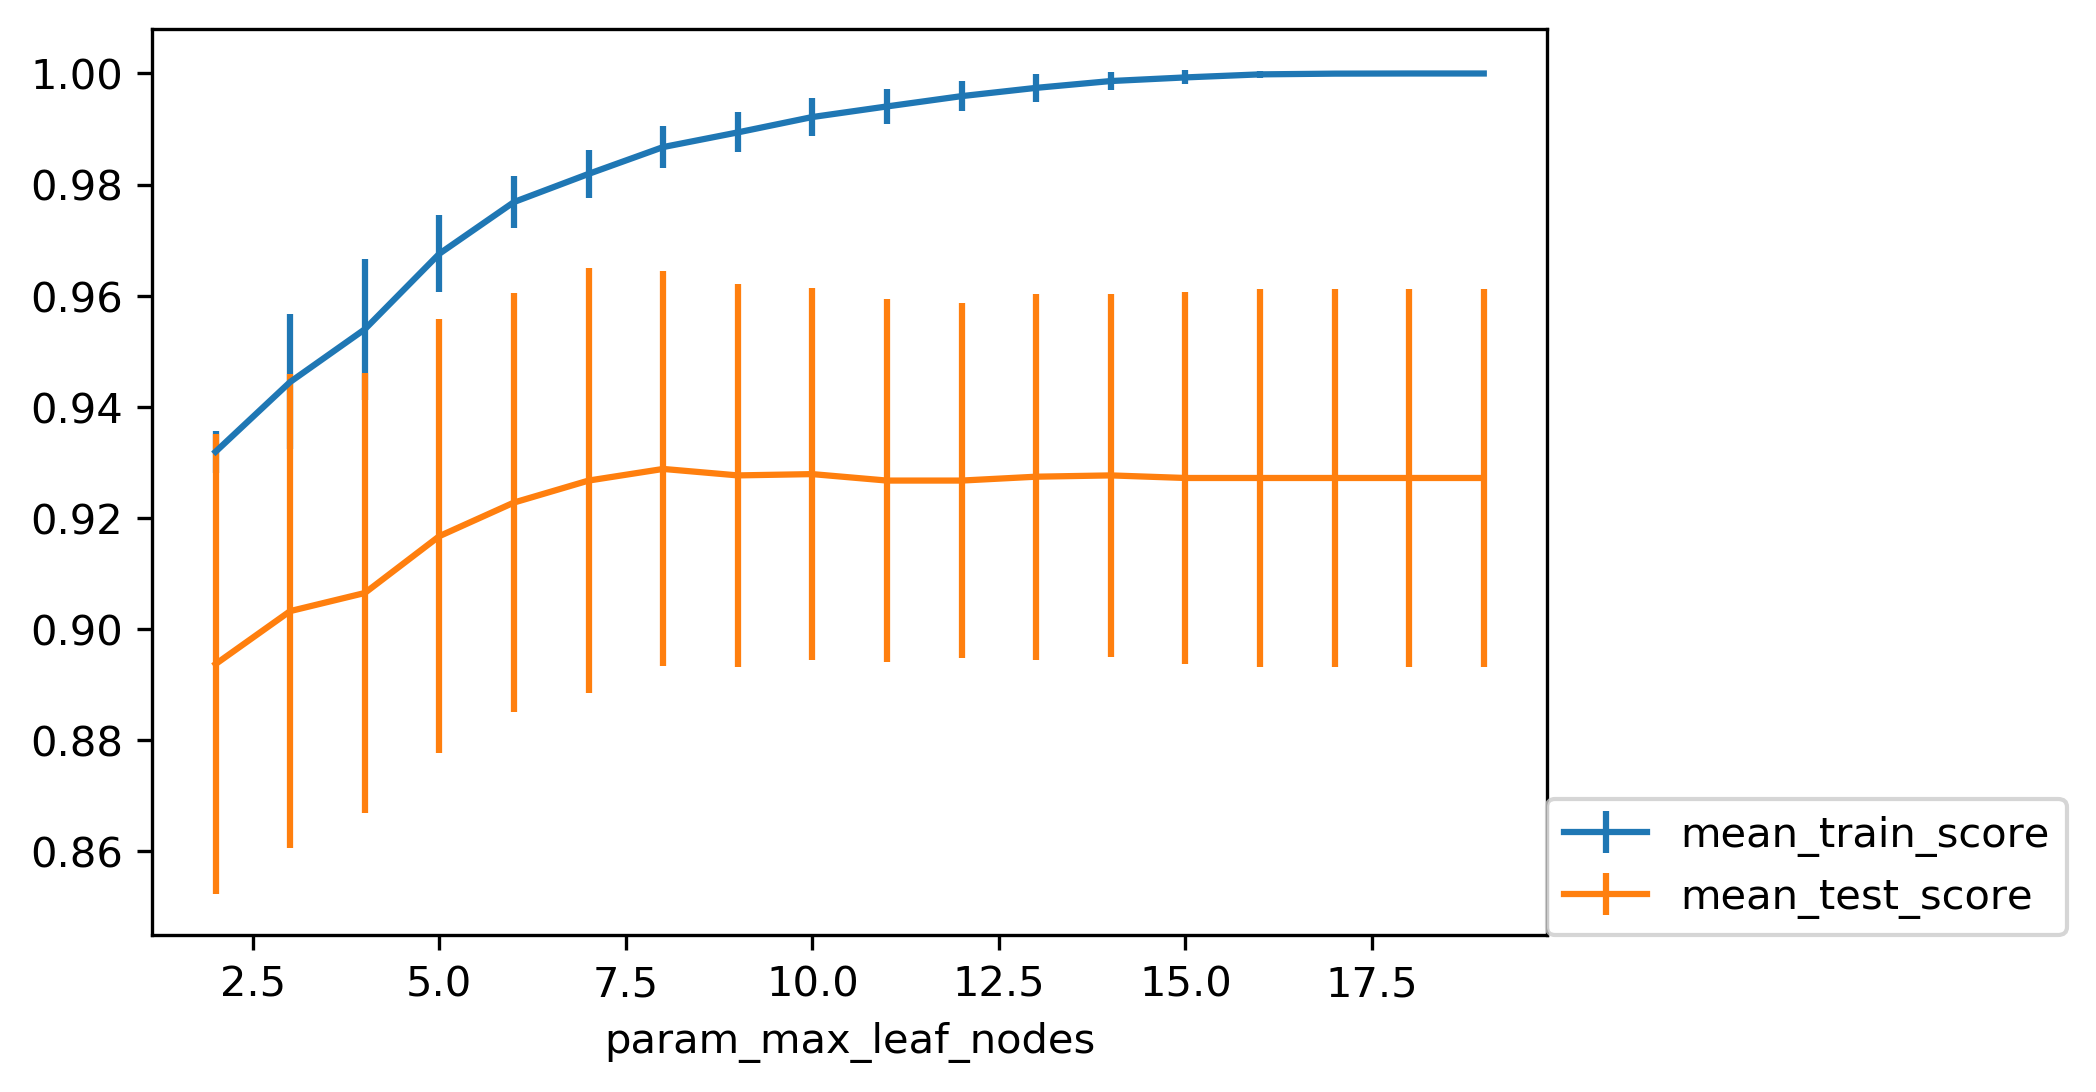

In [16]:
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_leaf_nodes', y='mean_test_score', yerr='std_test_score', ax=plt.gca())
plt.legend(loc=(1, 0))
plt.savefig("images/grid_max_leaf_nodes.png")

In [17]:
grid.best_params_

{'max_leaf_nodes': 8}

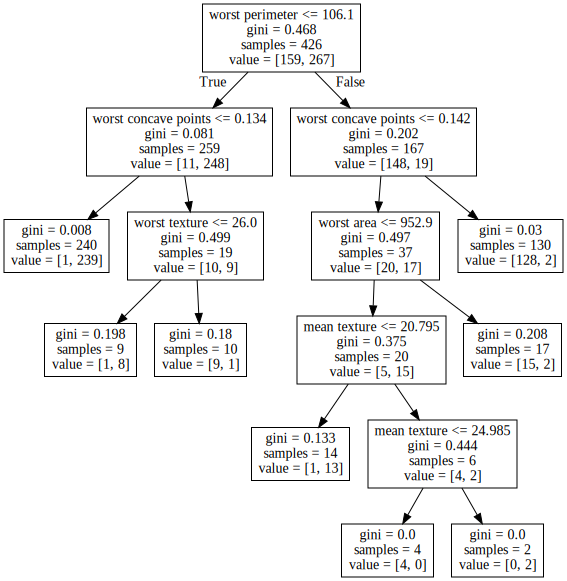

In [18]:
tree_dot = export_graphviz(grid.best_estimator_, out_file=None, feature_names=cancer.feature_names)
graph = graphviz.Source(tree_dot, format="png")
graph

# Cost-complexity pruning

In [19]:
# cheating a bit to get a good grid:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

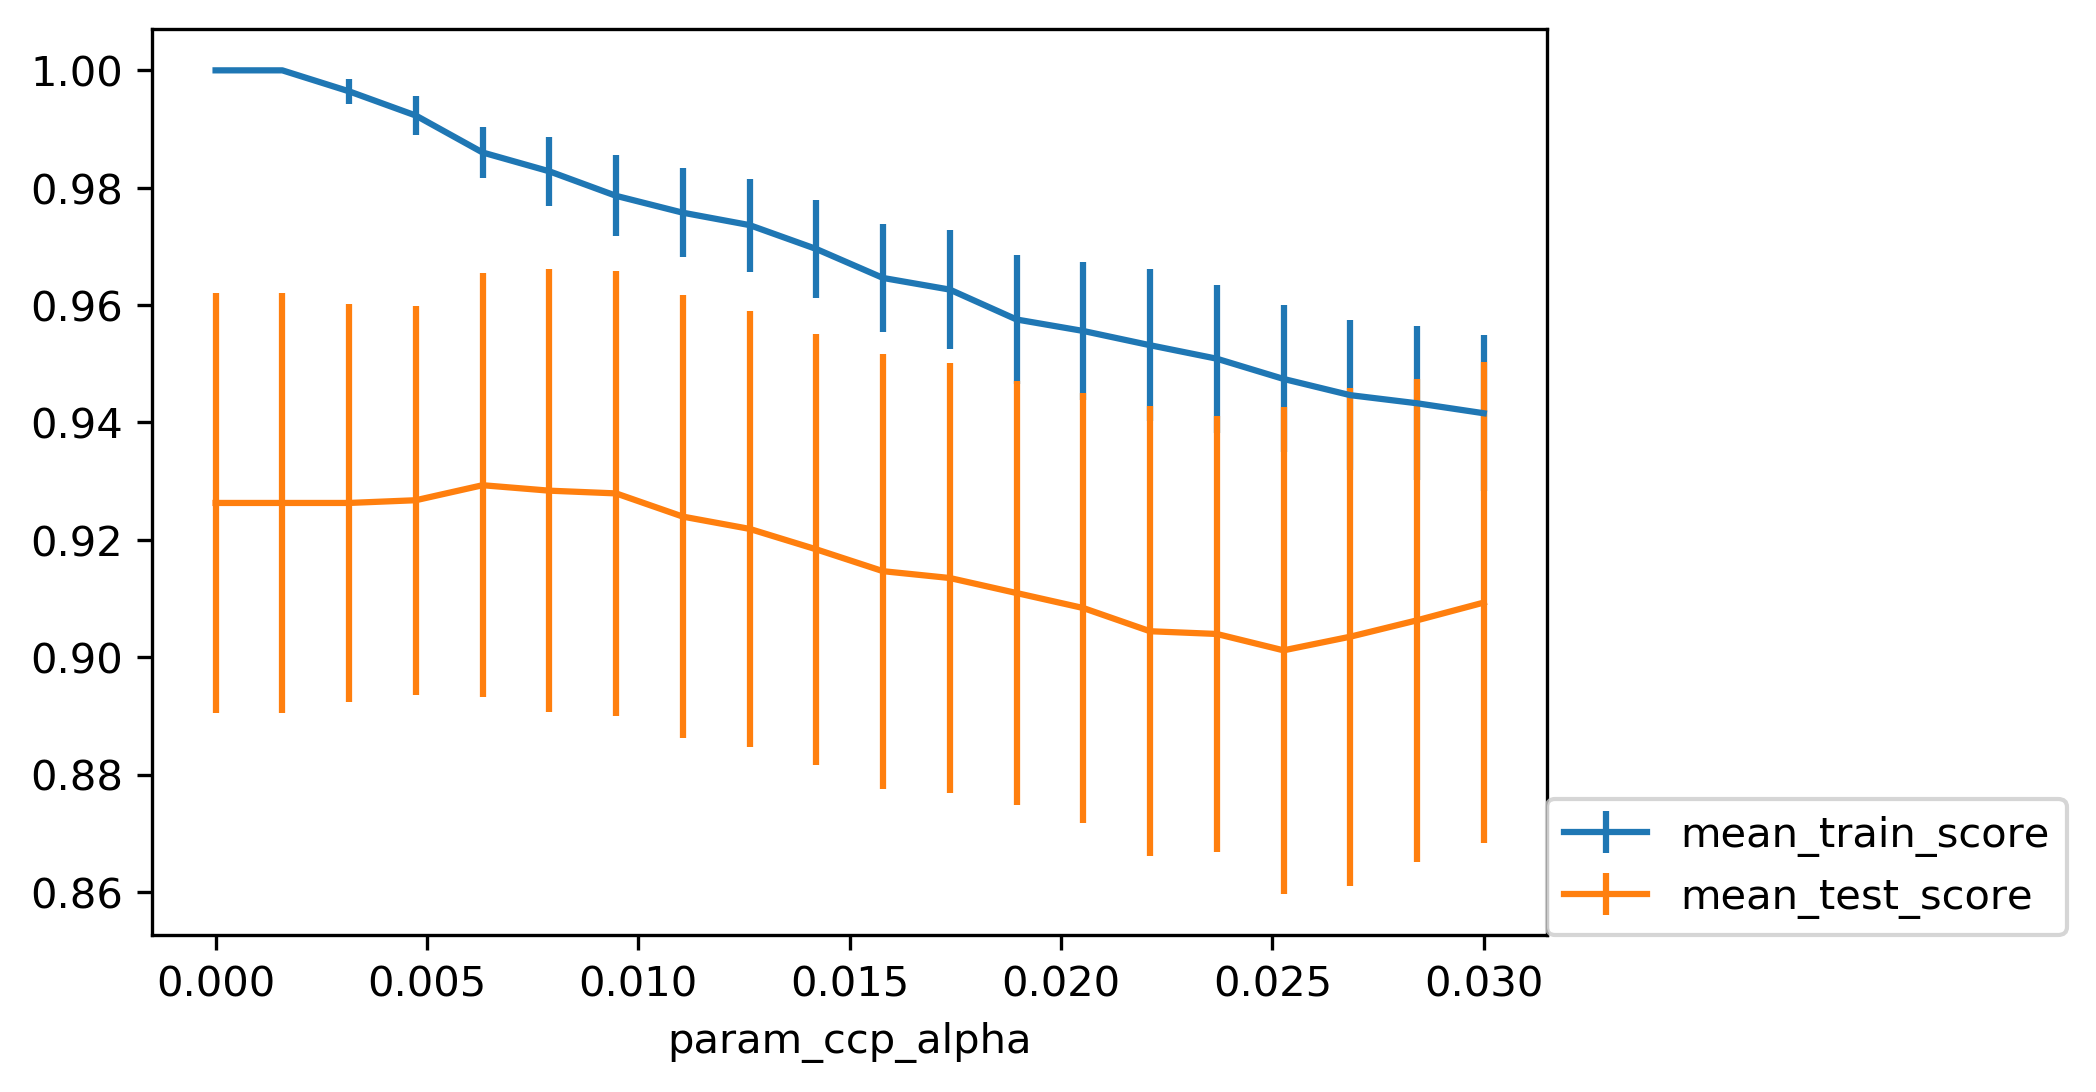

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {'ccp_alpha': [0., 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.014, 0.017, 0.023, 0.027]}
param_grid = {'ccp_alpha': np.linspace(0., 0.03, 20)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid,
                    cv=StratifiedShuffleSplit(100, random_state=1), return_train_score=True)
grid.fit(X_train, y_train)

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=plt.gca())
plt.legend(loc=(1, 0))
plt.savefig("images/grid_ccp_alpha.png")

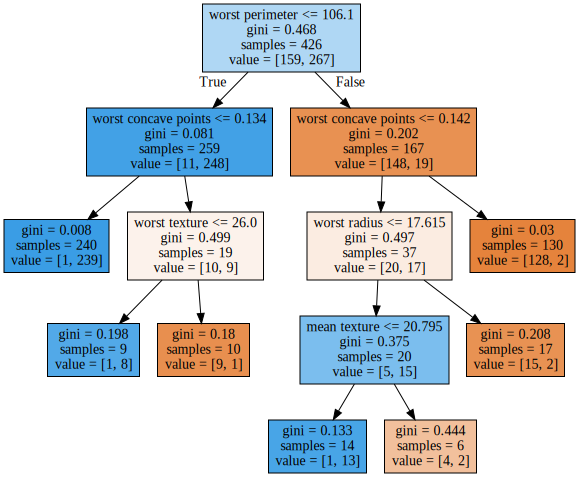

In [21]:
tree_dot = export_graphviz(grid.best_estimator_, out_file=None, feature_names=cancer.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/tree_pruned", cleanup=True)
graph

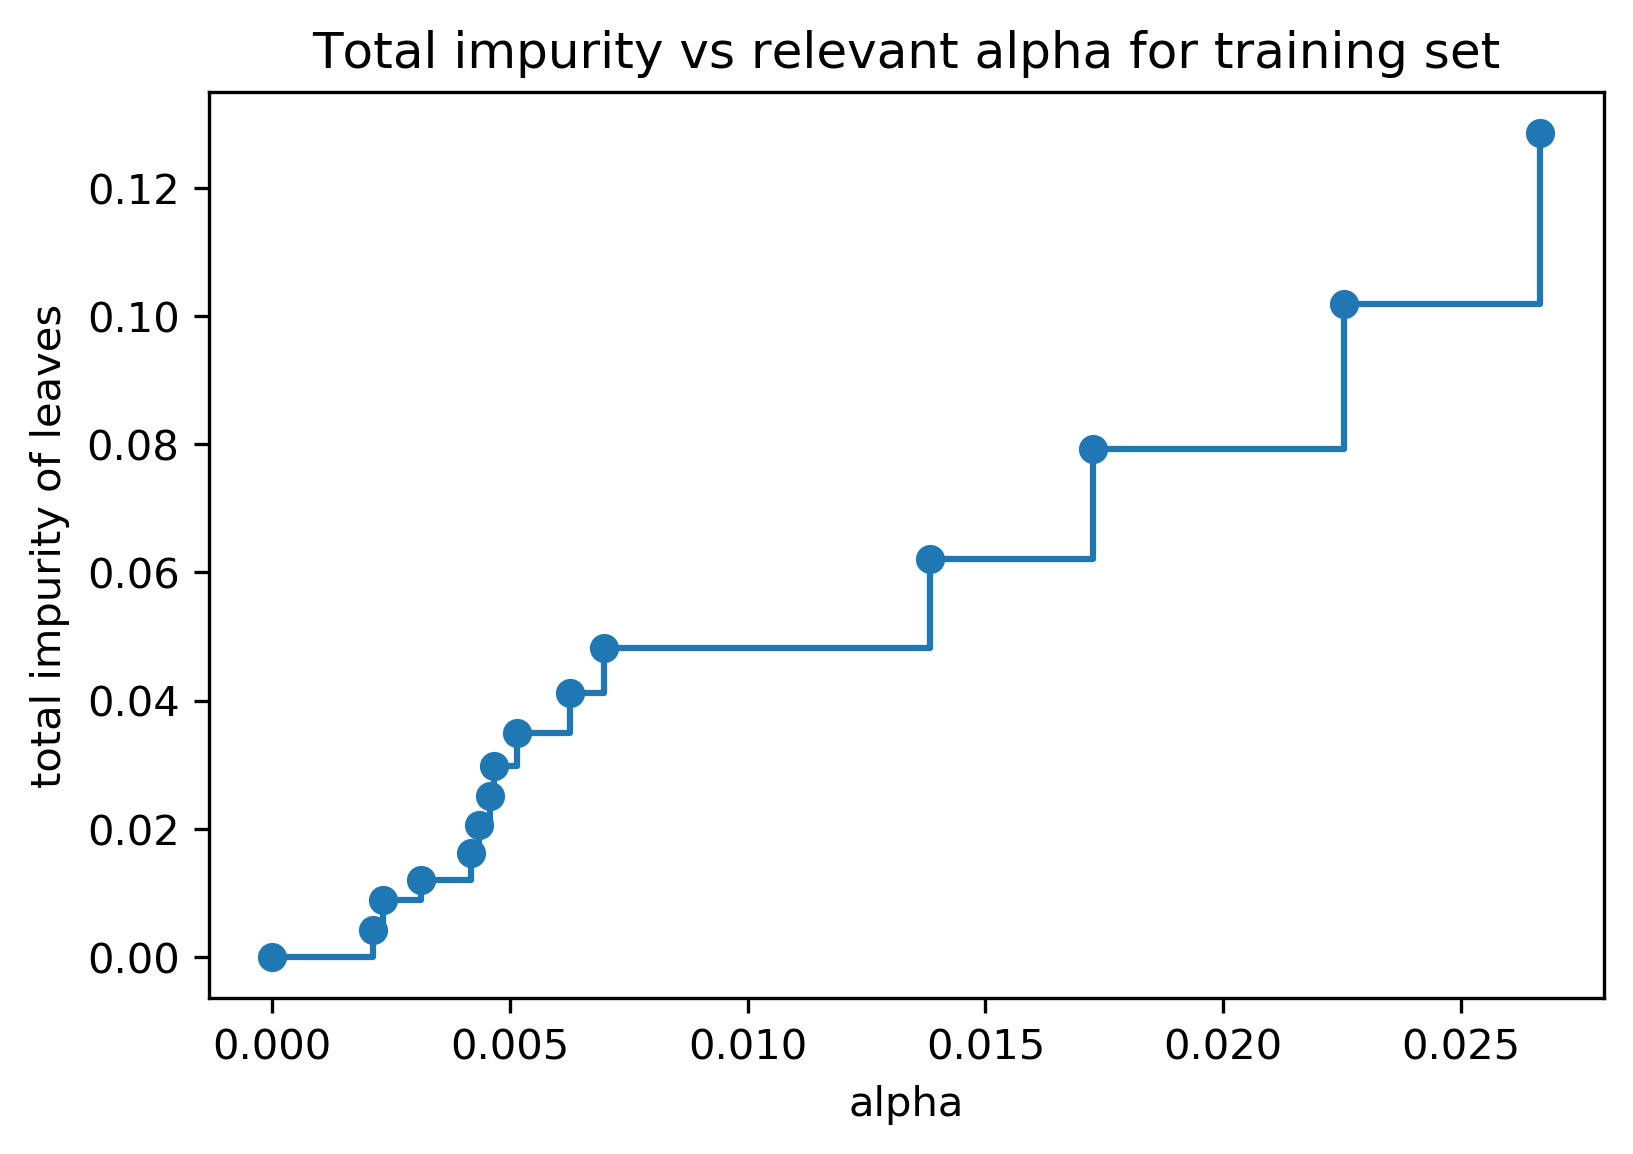

In [47]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total impurity vs relevant alpha for training set")
plt.savefig("images/pruning_alpha.png")

# Voting Classifier

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.datasets import make_moons
X, y = make_moons(noise=.2, random_state=18) # carefully picked random state for illustration
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

voting = VotingClassifier([('logreg', LogisticRegression(C=100)),
                           ('tree', DecisionTreeClassifier(max_depth=3, random_state=0))],
                         voting='soft')
voting.fit(X_train, y_train)
lr, tree = voting.estimators_
print(("{:.2f} " * 3).format(voting.score(X_test, y_test),
                             lr.score(X_test, y_test), tree.score(X_test, y_test)))


0.88 0.84 0.80 


In [50]:
x_lin = np.linspace(X_train[:, 0].min() - .5, X_train[:, 0].max() + .5, 100)
y_lin = np.linspace(X_train[:, 1].min() - .5, X_train[:, 1].max() + .5, 100)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
# transform produces individual probabilities
y_probs =  voting.transform(X_grid)

In [51]:
y_probs.shape

(10000, 4)

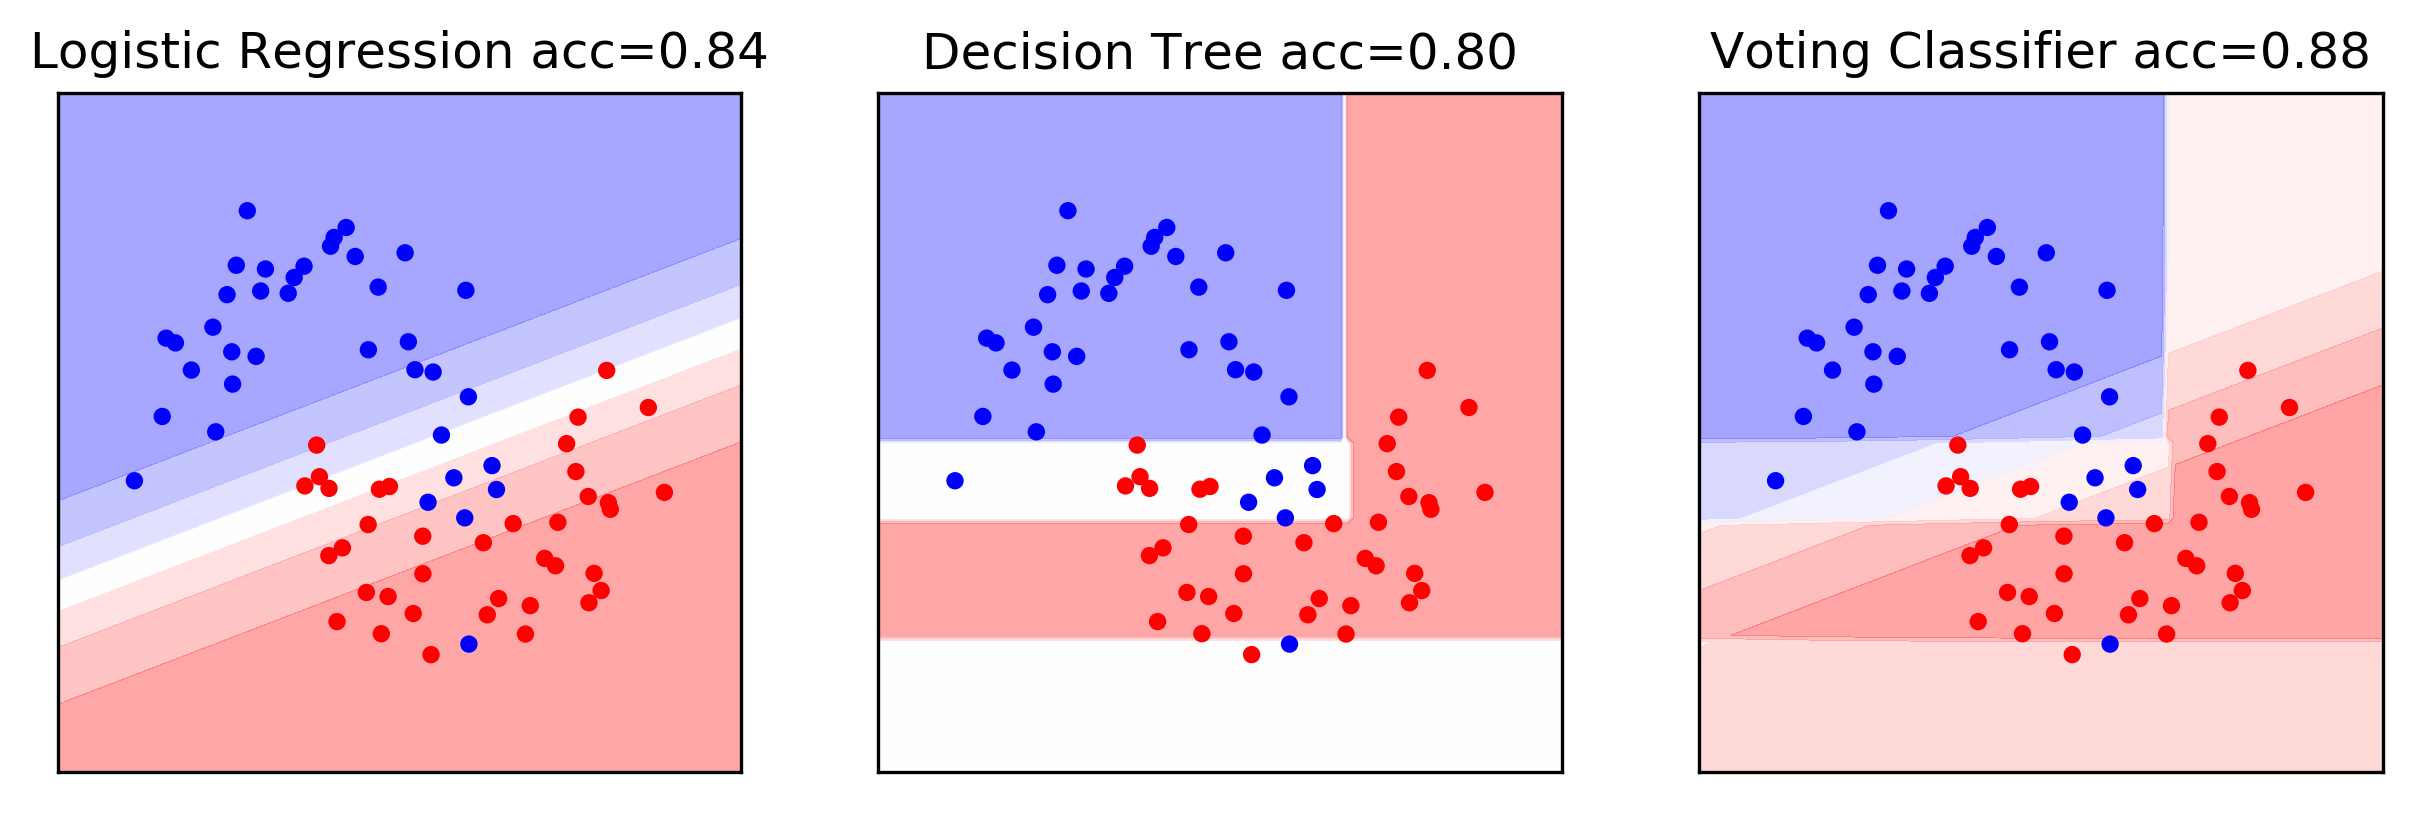

In [56]:
fig, axes = plt.subplots(1, 3, subplot_kw={'xticks': (()), 'yticks': (())}, figsize=(10, 3))
scores = [voting.estimators_[0].score(X_test, y_test),
         voting.estimators_[1].score(X_test, y_test),
         voting.score(X_test, y_test)]
titles = ['Logistic Regression', 'Decision Tree', 'Voting Classifier']
for prob, score, title, ax in zip([y_probs[:, 1], y_probs[:, 3], y_probs[:, 1::2].sum(axis=1)], scores, titles, axes.ravel()):
    ax.contourf(x_grid, y_grid, prob.reshape(x_grid.shape), alpha=.4, cmap='bwr')
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=10)
    ax.set_title(title + f" acc={score:.2f}")
plt.savefig("images/voting_classifier.png")

In [27]:
voting.estimators_[0].score(X_test, y_test)

0.84

In [28]:
voting.estimators_[1].score(X_test, y_test)

0.8

In [29]:
voting.score(X_test, y_test)

0.88

# Extrapolation

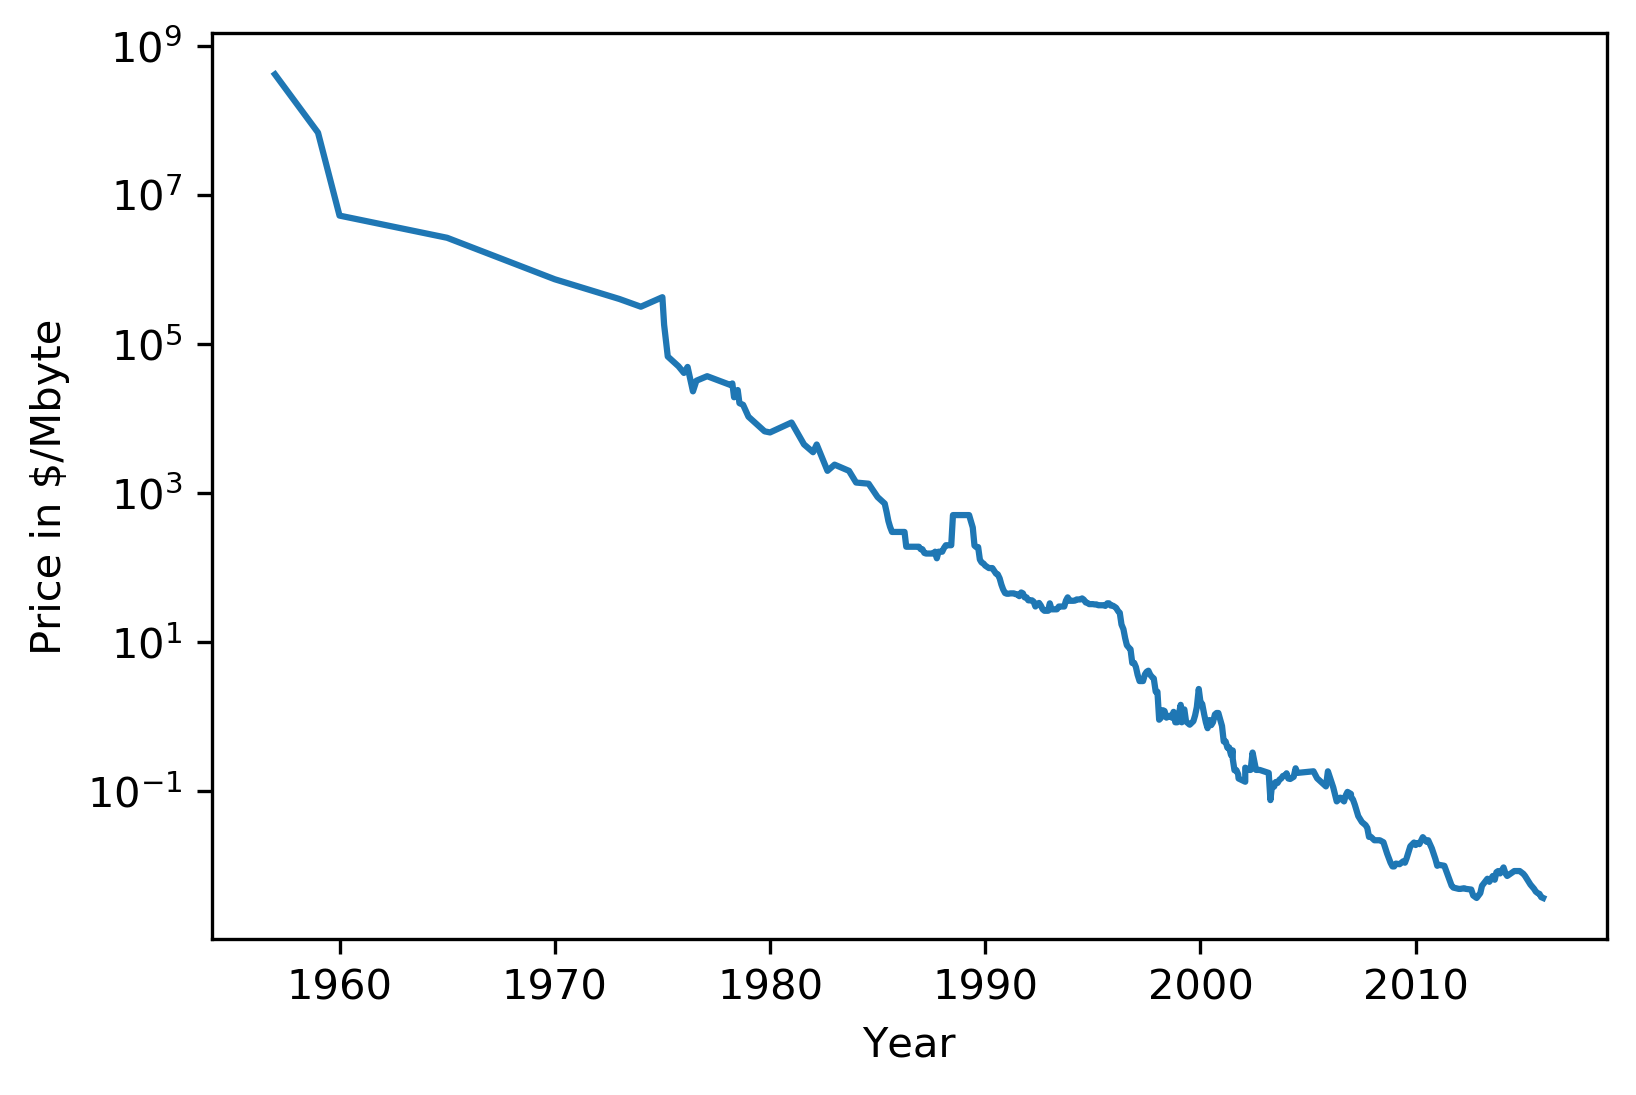

In [30]:
import os
ram_prices = pd.read_csv("ram_price.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.savefig("images/ram_prices.png")

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor(min_impurity_decrease=.1).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

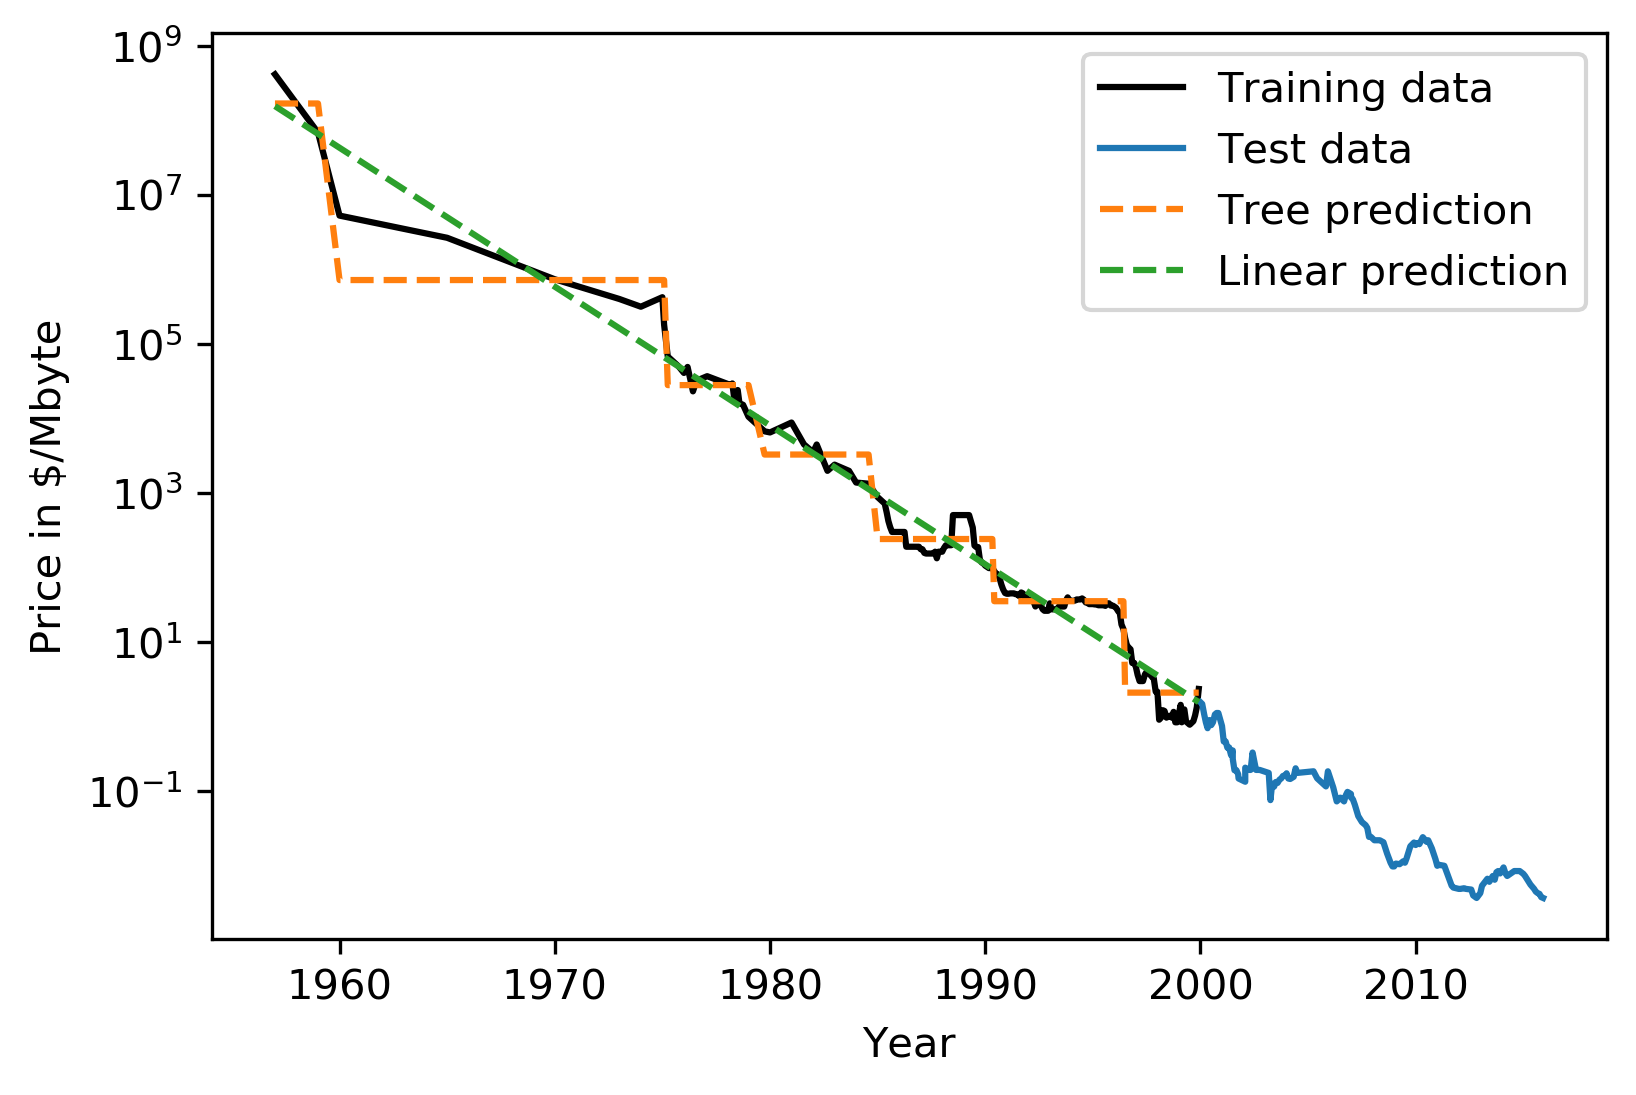

In [32]:
plt.semilogy(data_train.date, data_train.price, label="Training data", c='k')
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(data_train.date, np.exp(tree.predict(X_train)), '--', label="Tree prediction")
plt.semilogy(data_train.date, np.exp(linear_reg.predict(X_train)), '--', label="Linear prediction")
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.legend()
plt.savefig("images/ram_prices_train.png")
ylim = plt.ylim()

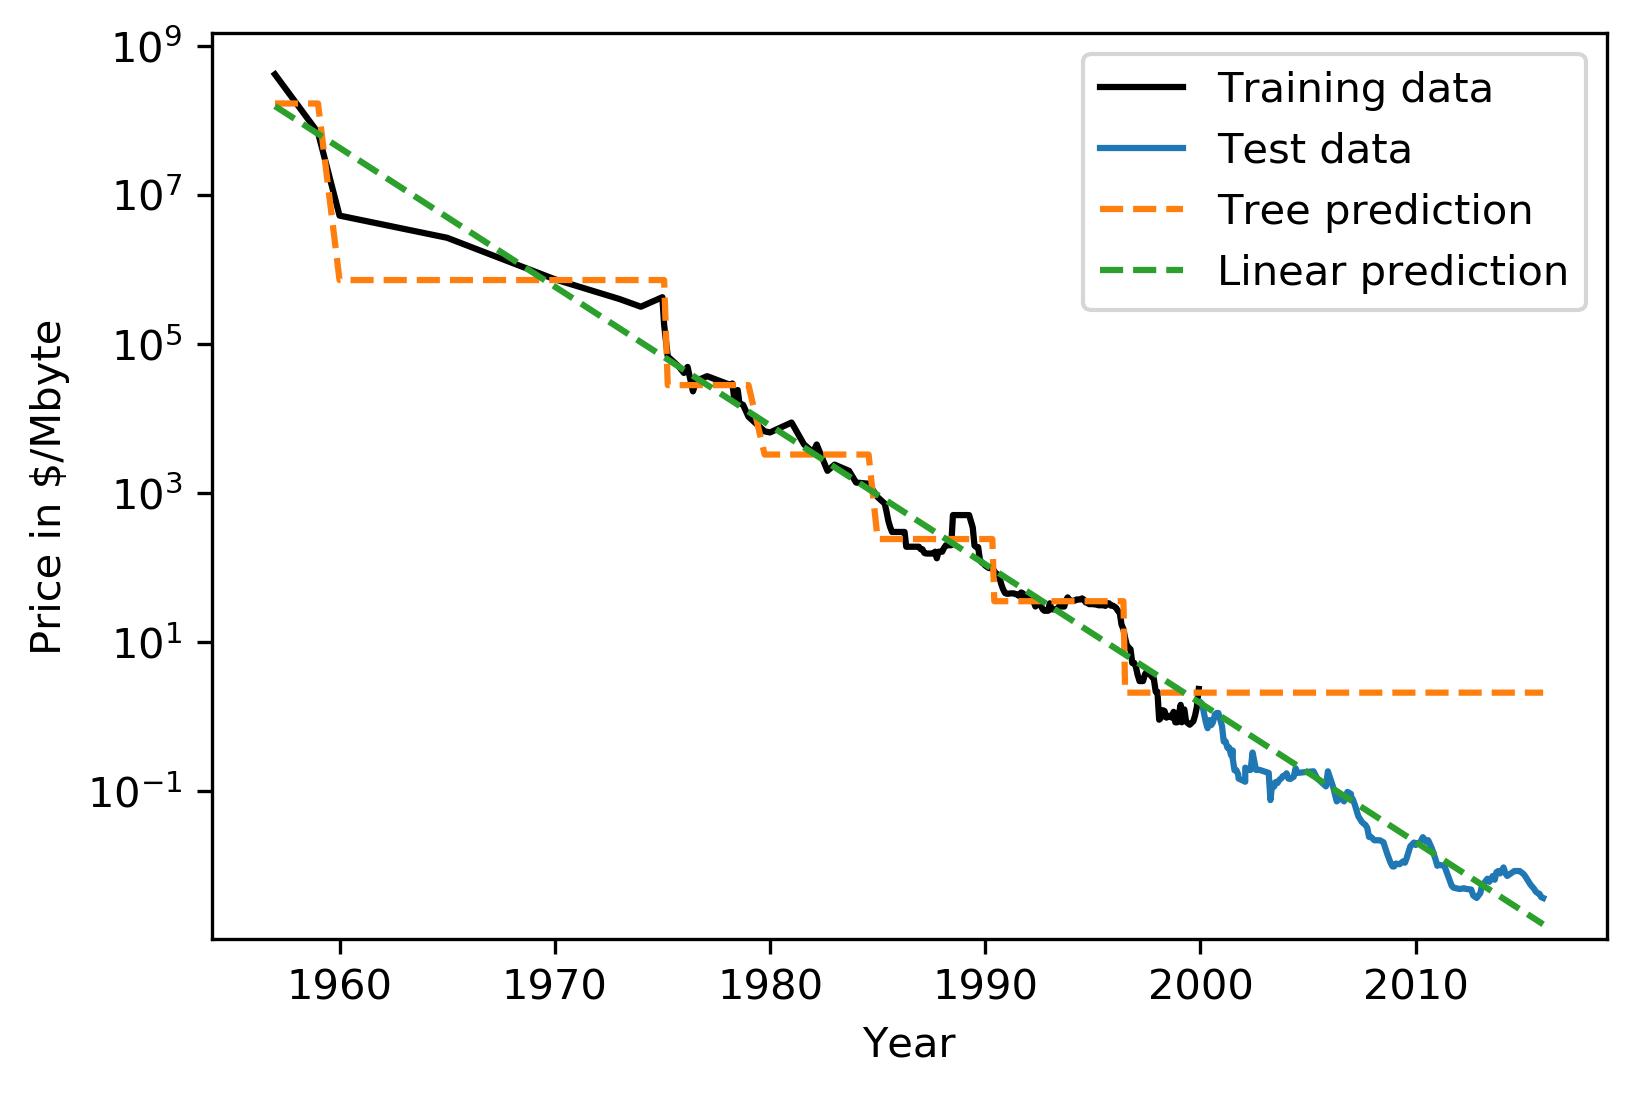

In [33]:
X_all = ram_prices.date[:, np.newaxis]
plt.semilogy(data_train.date, data_train.price, label="Training data", c='k')
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, np.exp(tree.predict(X_all)), '--', label="Tree prediction")
plt.semilogy(ram_prices.date, np.exp(linear_reg.predict(X_all)), '--', label="Linear prediction")
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")
plt.legend()
plt.ylim(ylim)
plt.savefig("images/ram_prices_test.png")


# instability

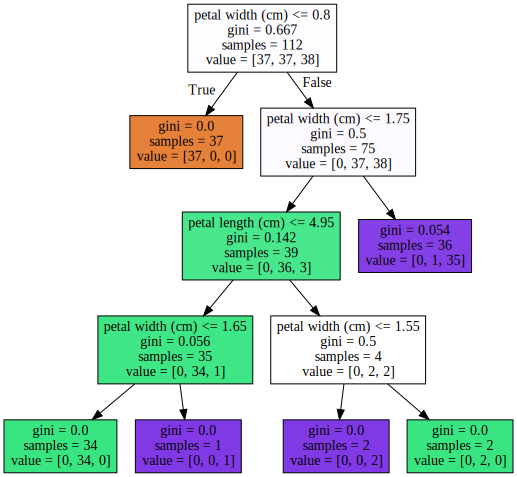

In [34]:
from sklearn.datasets import load_iris
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=0)
tree = DecisionTreeClassifier(max_leaf_nodes=6).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=iris.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="images/instability_1", cleanup=True)
graphviz.Source(tree_dot)

In [35]:
tree.feature_importances_

array([0.   , 0.   , 0.022, 0.978])

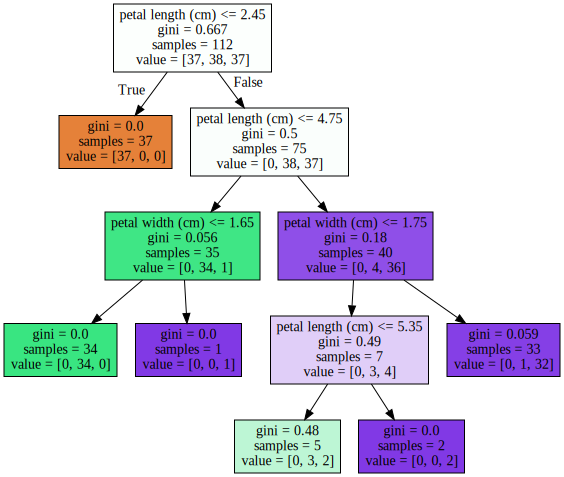

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=13)
tree = DecisionTreeClassifier(max_leaf_nodes=6).fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names=iris.feature_names, filled=True)
graph = graphviz.Source(tree_dot, format="png")

graph.render(filename="images/instability_2", cleanup=True)
graphviz.Source(tree_dot)

In [37]:
tree.feature_importances_

array([0.   , 0.   , 0.946, 0.054])

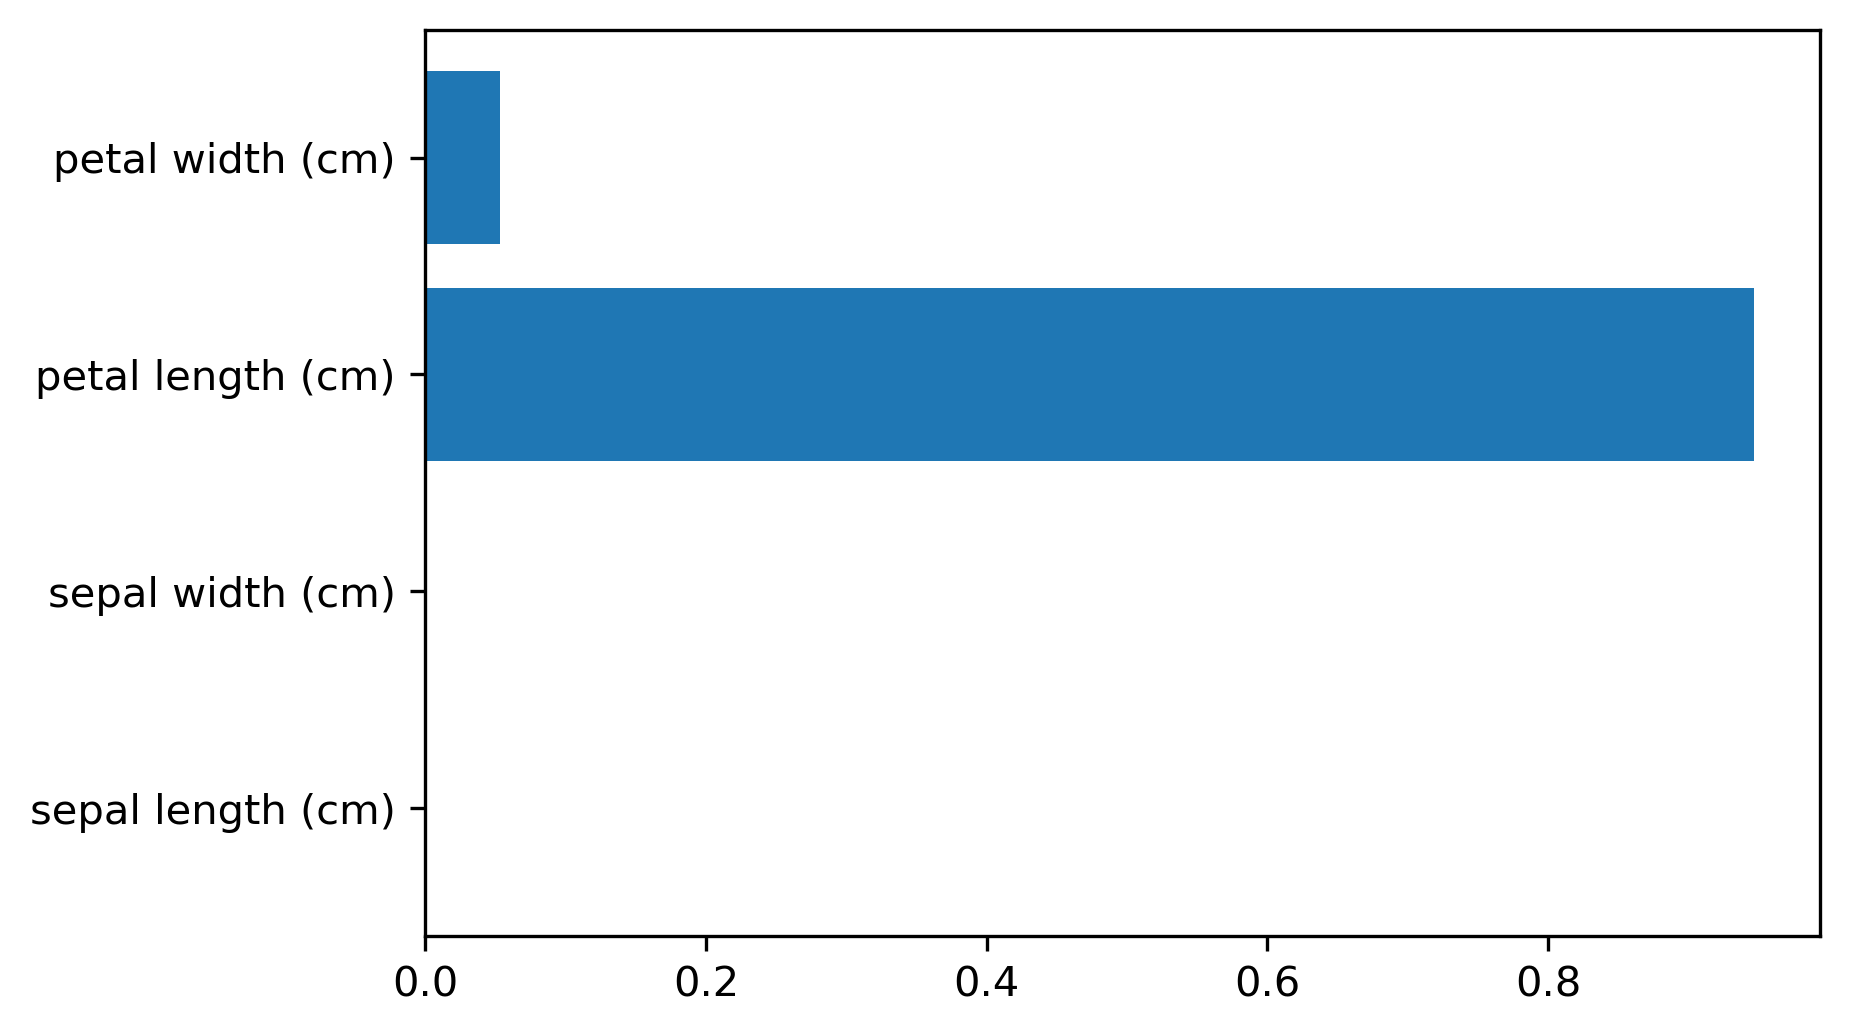

In [38]:
plt.barh(range(4), tree.feature_importances_)
plt.yticks(range(4), iris.feature_names)
plt.savefig("images/tree_importances.png")

# Random Forests

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, stratify=digits.target, random_state=0)

In [40]:
train_scores = []
test_scores = []

rf = RandomForestClassifier(warm_start=True, random_state=0)
estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

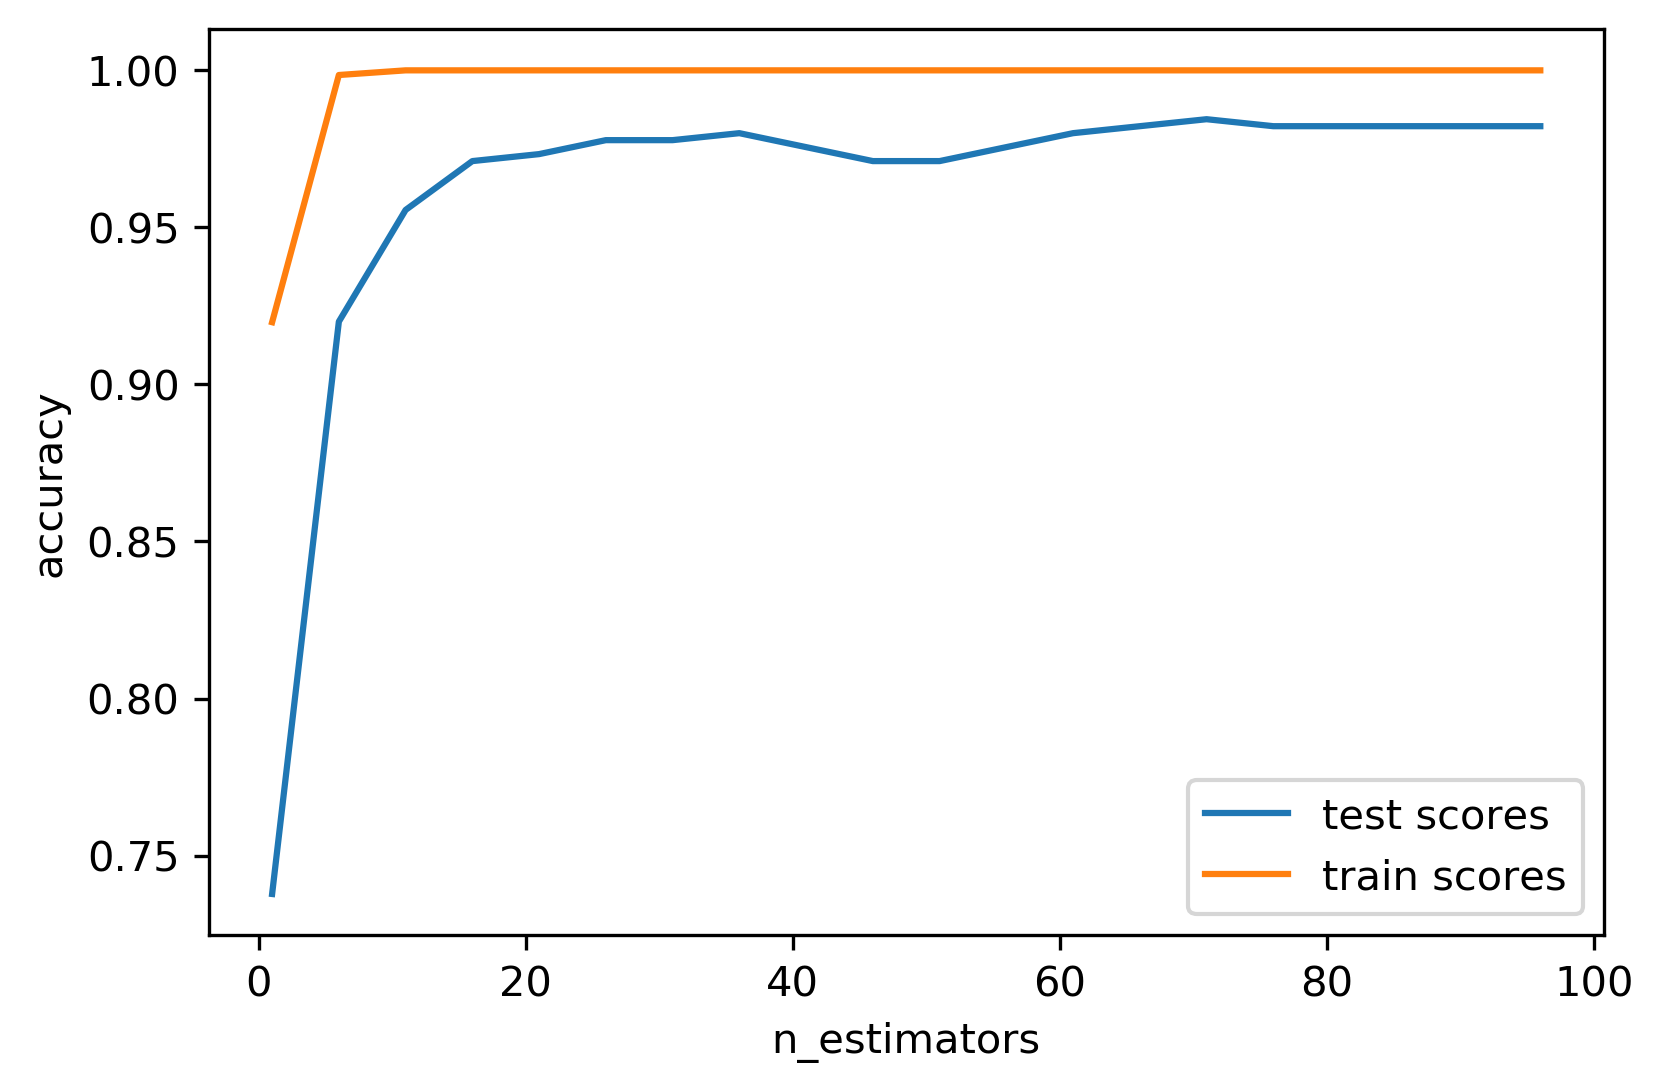

In [41]:
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
plt.savefig("images/warm_start_forest.png")

In [42]:
train_scores = []
test_scores = []
oob_scores = []

feature_range = range(1, 64, 5)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True, n_estimators=200, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)

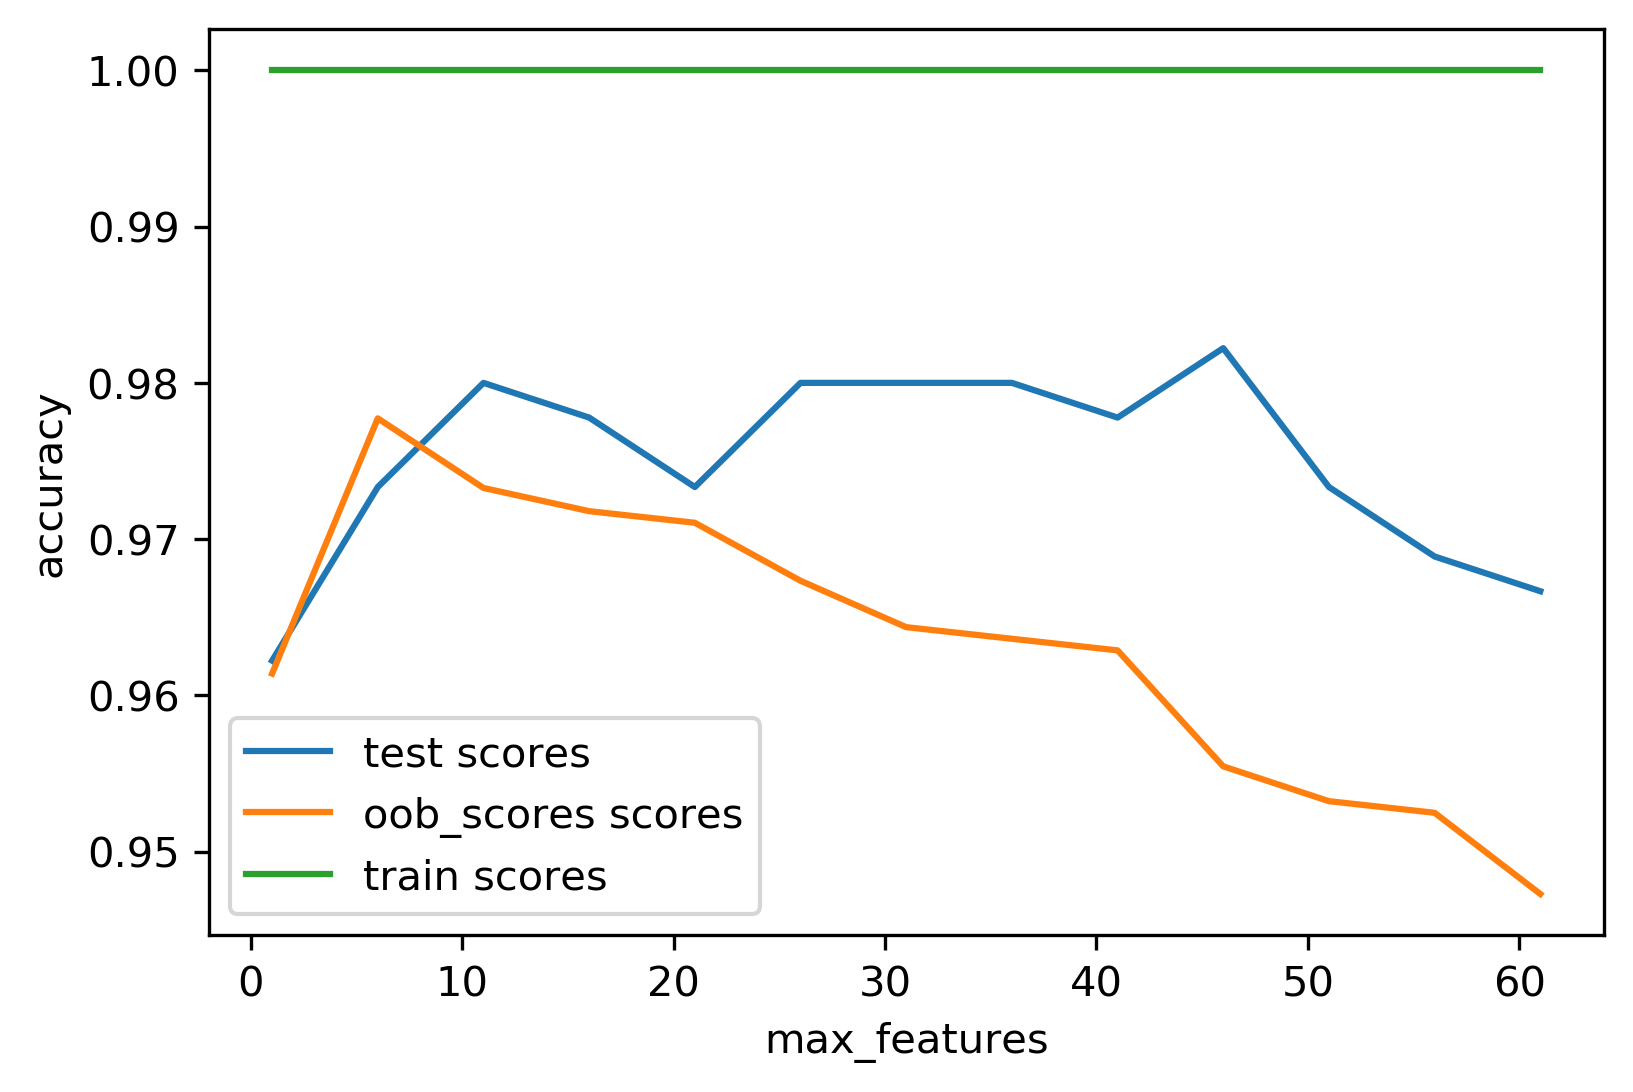

In [43]:
plt.plot(feature_range, test_scores, label="test scores")
plt.plot(feature_range, oob_scores, label="oob_scores scores")
plt.plot(feature_range, train_scores, label="train scores")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("max_features")
plt.savefig("images/oob_estimates.png")

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=1)
rf = RandomForestClassifier().fit(X_train, y_train)

In [45]:
rf.feature_importances_

array([0.112, 0.031, 0.461, 0.395])

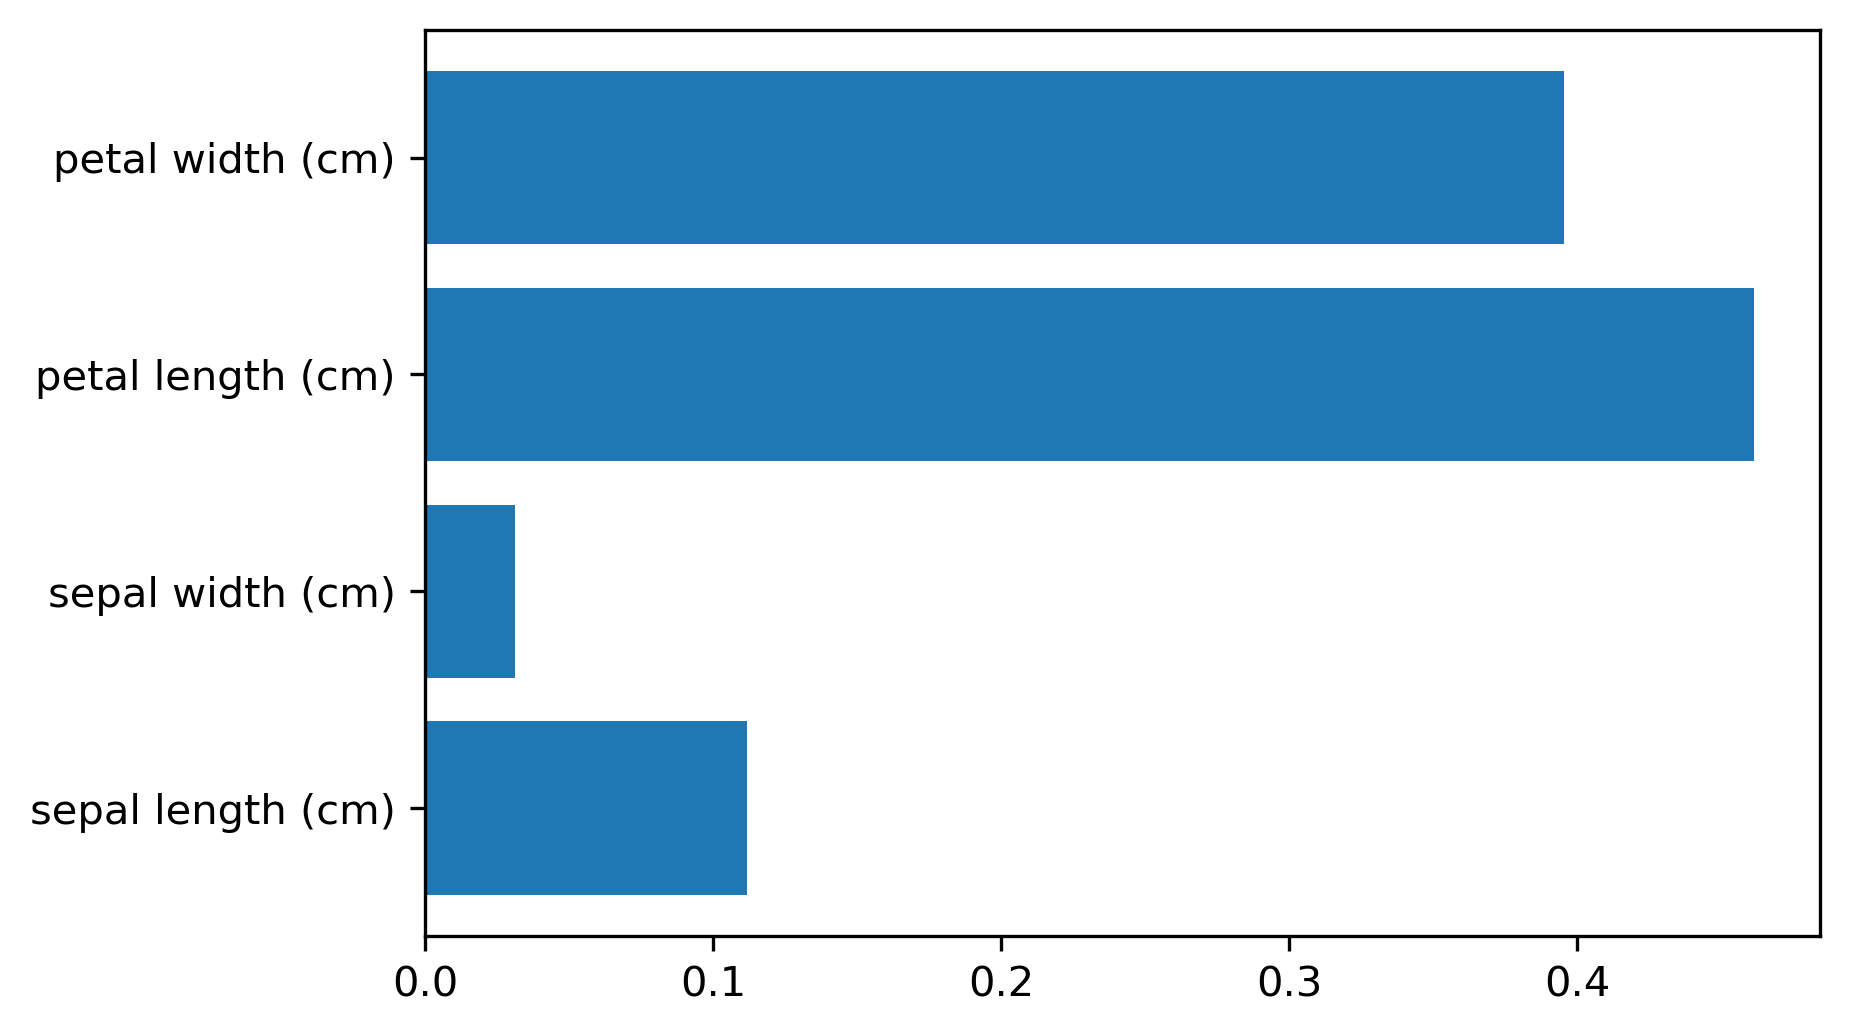

In [46]:
plt.barh(range(4), rf.feature_importances_)
plt.yticks(range(4), iris.feature_names)
plt.savefig("images/forest_importances.png")